In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from scipy import stats

%matplotlib inline
# plt.style.use('ggplot')

# HELPER FUNCTIONS

In [2]:
def read_data(file_path, column_names):
    """Reads the data from the specified file and retrieves the column names
    
    Args:
        file_path: The path of the file as a String
        column_names: Array of Strings representing the names of the colunms
        
    Returns:
        A DataFrame of the read in data
    """
    data = pd.read_csv(file_path, header = 0, names = column_names)
    return data

def feature_normalize(dataset):
    """Normalizes the data in the DataFrame using the mean and sigma values
    
    Args:
        dataset: The DataFrame to normalize
        
    Returns:
        The normalized data
    """
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def basic_feature_normalize(dataset, cols_to_norm):
    """A Basic Normalization of the dataset
    
    Takes the dataset and normalizes it from 0 (min value) to 1 (max value)
    
    Args:
        dataset: The DataFrame to normalize
        cols_to_norm: An Array of strings of the columns that need normalization
        
    Returns:
        The normalized dataset with the specified columns normalized between 0 and 1
    """
    dataset[cols_to_norm] = dataset[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return dataset

def make_rgbs(dataset, cols_to_rgb):
    """Takes a dataset and converts specific columns into rgb values
    
    Args:
        dataset: The DataFrame to convert to rgb values
        cols_to_rgb: An Arrya of strings of the columns that need to be converted
        
    Returns:
        The dataset with the specified columns converted to rgb values
    """
    dataset[cols_to_rgb] = dataset[cols_to_rgb].apply(lambda x: int(x * 255))
    return dataset

def convert_timestamp(dataset):
    """Converts the timestamp to a unix timestamp
    
    Args:
        dataset: The DataFrame with the timestamp column to convert to unix
        
    Returns:
        The dataset with the converted timestamp
    """
    dataset['Timestamp'] = dataset['Timestamp'].apply(lambda x:
                                                     datetime.strptime(x, '%m/%d/%y %H:%M').timestamp())
    return dataset

def convert_BGA_RFU(dataset, threshold):
    """Converts the BGA_Phycocyanin_RFU column to a true or false value (represented by 1 or 0)
       based on the threshold value
       
    Args:
        dataset: The DataFrame with the BGA_Phycocyanin_RFU value to be adjusted
        threshold: The minimum value for an algae bloom to be true
        
    Returns:
        The dataset with the converted BGA_RFU value"""
    dataset['BGA_Phycocyanin_RFU'] = dataset['BGA_Phycocyanin_RFU'].apply(lambda x: 1 if x >= threshold else 0)
    return dataset

# Batch Creation

In [13]:
# We step 50% down based on window size
def windows(data, size):
    counter_output = 0
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 12)
        counter_output += 1
        if counter_output % 10 == 0:
            print('Window Segmentation {0:.2f}% done'.format((start / data.count()) * 100))
    
# 32 chosen for 8 hours of 15 minute intervals
# TODO: NEED TO PASS IN COLUMNS AND DETERMINE FROM THAT
def segment_signal(dataset, window_size = 90, columns = 5):
    segments = np.empty((0, window_size, columns))
    labels = np.empty((0))
    count = 0;
    for (start, end) in windows(dataset["Timestamp"], window_size):
        temperature = dataset['Temperature'][start:end]
        conductivity = dataset['Sp_Cond'][start:end]
        turbidity = dataset['Turbidity'][start:end]
#         ph = dataset['pH'][start:end]
#         odo = dataset['ODO'][start:end]
        if(len(dataset['Timestamp'][start:end]) == window_size):
            segments = np.vstack([segments, np.dstack([temperature, conductivity, turbidity])])
            labels = np.append(labels, stats.mode(dataset['BGA_Phycocyanin_RFU'][start:end])[0][0])
    return segments, labels

# Setup the Lake_Dataset

In [14]:
cols = ['Timestamp', 'Temperature', 'Sp_Cond', 'pH_mV', 'pH', 'Turbidity', 'Chlorophyll', 'Chlorophyll_RFU',
        'ODOSat', 'ODO', 'BGA_Phycocyanin_RFU']

cols_to_keep = []
cols_to_keep.append('Timestamp')
cols_to_keep.append('Temperature')
cols_to_keep.append('Sp_Cond')
# cols_to_keep.append('pH_mV')
cols_to_keep.append('pH')
cols_to_keep.append('Turbidity')
# cols_to_keep.append('Chlorophyll')
# cols_to_keep.append('Chlorophyll_RFU')
# cols_to_keep.append('ODOSat')
cols_to_keep.append('ODO')
cols_to_keep.append('BGA_Phycocyanin_RFU')

lake_dataset = read_data('./data/cleaned/utah_lake_vineyard.csv', cols) 

for col in cols:
    if col not in cols_to_keep:
        lake_dataset = lake_dataset.drop(col, axis=1)
        
lake_dataset = convert_timestamp(lake_dataset)
# lake_dataset = convert_BGA_RFU(lake_dataset, 1.0)
lake_dataset.head()

,Timestamp,Temperature,Sp_Cond,pH,Turbidity,ODO,BGA_Phycocyanin_RFU
0,1.493960e+09,15.02,1848,8.36,16.84,9.04,0.4
1,1.493961e+09,14.99,1847,8.36,16.76,9.04,0.4
2,1.493962e+09,14.96,1847,8.36,16.82,9.04,0.4
3,1.493963e+09,14.95,1848,8.36,17.19,9.03,0.4
4,1.493964e+09,14.92,1848,8.36,16.85,9.02,0.4


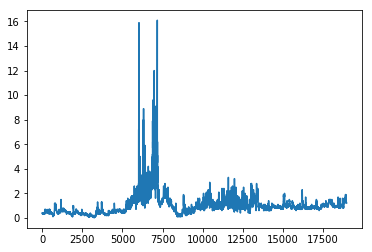

In [27]:
plt.plot(lake_dataset['BGA_Phycocyanin_RFU'])
# plt.plot(lake_dataset['Temperature'])
# plt.plot(lake_dataset['ODO'])
# plt.plot(lake_dataset['pH'])

In [16]:
normalized_lake_dataset = basic_feature_normalize(lake_dataset, ['Temperature', 'Sp_Cond', 'Turbidity', 'pH', 'ODO'])
normalized_lake_dataset.head()

,Timestamp,Temperature,Sp_Cond,pH,Turbidity,ODO,BGA_Phycocyanin_RFU
0,1.493960e+09,0.409329,0.853771,0.330769,0.025439,0.351818,0.4
1,1.493961e+09,0.408021,0.853309,0.330769,0.025313,0.351818,0.4
2,1.493962e+09,0.406713,0.853309,0.330769,0.025407,0.351818,0.4
3,1.493963e+09,0.406277,0.853771,0.330769,0.025989,0.350909,0.4
4,1.493964e+09,0.404969,0.853771,0.330769,0.025454,0.350000,0.4


In [17]:
normalized_lake_dataset['Temperature'].max()

1.0

In [18]:
normalized_lake_dataset['Temperature'].min()

0.0

In [19]:
normalized_lake_dataset.shape

(18947, 7)

# Retrieve the segments and labels

In [20]:
segments, labels = segment_signal(normalized_lake_dataset, 36, 3)

Window Segmentation 0.16% done
Window Segmentation 0.32% done
Window Segmentation 0.48% done
Window Segmentation 0.63% done
Window Segmentation 0.79% done
Window Segmentation 0.95% done
Window Segmentation 1.11% done
Window Segmentation 1.27% done
Window Segmentation 1.43% done
Window Segmentation 1.58% done
Window Segmentation 1.74% done
Window Segmentation 1.90% done
Window Segmentation 2.06% done
Window Segmentation 2.22% done
Window Segmentation 2.38% done
Window Segmentation 2.53% done
Window Segmentation 2.69% done
Window Segmentation 2.85% done
Window Segmentation 3.01% done
Window Segmentation 3.17% done
Window Segmentation 3.33% done
Window Segmentation 3.48% done
Window Segmentation 3.64% done
Window Segmentation 3.80% done
Window Segmentation 3.96% done
Window Segmentation 4.12% done
Window Segmentation 4.28% done
Window Segmentation 4.43% done
Window Segmentation 4.59% done
Window Segmentation 4.75% done
Window Segmentation 4.91% done
Window Segmentation 5.07% done
Window S

Window Segmentation 41.17% done
Window Segmentation 41.33% done
Window Segmentation 41.48% done
Window Segmentation 41.64% done
Window Segmentation 41.80% done
Window Segmentation 41.96% done
Window Segmentation 42.12% done
Window Segmentation 42.28% done
Window Segmentation 42.43% done
Window Segmentation 42.59% done
Window Segmentation 42.75% done
Window Segmentation 42.91% done
Window Segmentation 43.07% done
Window Segmentation 43.23% done
Window Segmentation 43.38% done
Window Segmentation 43.54% done
Window Segmentation 43.70% done
Window Segmentation 43.86% done
Window Segmentation 44.02% done
Window Segmentation 44.18% done
Window Segmentation 44.33% done
Window Segmentation 44.49% done
Window Segmentation 44.65% done
Window Segmentation 44.81% done
Window Segmentation 44.97% done
Window Segmentation 45.13% done
Window Segmentation 45.28% done
Window Segmentation 45.44% done
Window Segmentation 45.60% done
Window Segmentation 45.76% done
Window Segmentation 45.92% done
Window S

Window Segmentation 81.86% done
Window Segmentation 82.02% done
Window Segmentation 82.18% done
Window Segmentation 82.33% done
Window Segmentation 82.49% done
Window Segmentation 82.65% done
Window Segmentation 82.81% done
Window Segmentation 82.97% done
Window Segmentation 83.13% done
Window Segmentation 83.28% done
Window Segmentation 83.44% done
Window Segmentation 83.60% done
Window Segmentation 83.76% done
Window Segmentation 83.92% done
Window Segmentation 84.08% done
Window Segmentation 84.23% done
Window Segmentation 84.39% done
Window Segmentation 84.55% done
Window Segmentation 84.71% done
Window Segmentation 84.87% done
Window Segmentation 85.03% done
Window Segmentation 85.18% done
Window Segmentation 85.34% done
Window Segmentation 85.50% done
Window Segmentation 85.66% done
Window Segmentation 85.82% done
Window Segmentation 85.98% done
Window Segmentation 86.14% done
Window Segmentation 86.29% done
Window Segmentation 86.45% done
Window Segmentation 86.61% done
Window S

In [21]:
segments.shape

(6304, 36, 3)

In [22]:
reshaped_segments = segments.reshape(len(segments), 1, 36, 3)
reshaped_segments.shape

(6304, 1, 36, 3)

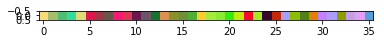

In [23]:
plt.imshow(reshaped_segments[0] * 255)

In [24]:
reshaped_segments_as_image = segments.reshape(len(segments), 6, 6, 3)

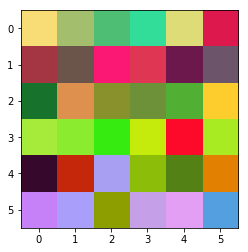

In [25]:
plt.imshow(reshaped_segments_as_image[0] * 255)

In [ ]:
labels[2000]

In [ ]:
plt.imshow(reshaped_segments_as_image[2000] * 255)

In [ ]:
labels[2010]

In [ ]:
plt.imshow(reshaped_segments_as_image[2010] * 255)

In [ ]:
labels[2020]

In [ ]:
plt.imshow(reshaped_segments_as_image[2020] * 255)

In [ ]:
labels[2030]

In [ ]:
plt.imshow(reshaped_segments_as_image[2030] * 255)

In [ ]:
segments.shape

In [26]:
reshaped_segments_as_image.shape

(6304, 6, 6, 3)

In [ ]:
labels.shape

In [ ]:
labels = labels.reshape(len(labels), 1)

In [ ]:
labels.shape

In [ ]:
new_labels = np.zeros((len(labels), 2))

In [ ]:
new_labels.shape

In [ ]:
new_labels[0][0]

In [ ]:
iter = 0
while(iter < len(labels)):
    new_labels[iter][int(labels[iter])] = 1
    iter = iter + 1

In [ ]:
new_labels[2000:2050]

In [ ]:
labels = new_labels

# Break apart the training and test data

In [ ]:
from sklearn.model_selection import train_test_split

class CNNHelper():
    
    def __init__(self):
        self.iterator = 0
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(reshaped_segments_as_image, labels, test_size=0.3, random_state=101)

    def next_batch(self, batch_size):
        x = self.X_train[self.iterator:self.iterator + batch_size]
        y = self.y_train[self.iterator:self.iterator + batch_size]
        self.iterator = (self.iterator + batch_size) % len(self.X_train)
        return x, y

# CREATE THE MODEL

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 6, 6, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 2])

In [ ]:
hold_prob = tf.placeholder(tf.float32)

In [ ]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [ ]:
convo_1 = convolutional_layer(x,shape=[2,2,3,6])
convo_1_pooling = max_pool_2by2(convo_1)

In [ ]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[2,2,6,12])
convo_2_pooling = max_pool_2by2(convo_2)

In [ ]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 4*12])

In [ ]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,64))

In [ ]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [ ]:
full_one_dropout.shape

In [ ]:
y_pred = normal_full_layer(full_one_dropout,2)
y_pred.shape

## Loss Function

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [ ]:
init = tf.global_variables_initializer()
cnn_helper = CNNHelper()

In [ ]:
cnn_helper.X_test.shape

In [ ]:
cnn_helper.X_test[0]

In [ ]:
# cnn_helper.X_test = np.zeros((1892, 6, 6, 3))
# cnn_helper.X_test[0]

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(4000):
        batch = cnn_helper.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:cnn_helper.X_test,y_true:cnn_helper.y_test,hold_prob:1.0}))
            print('\n')

In [ ]:
print(_)